In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

spark = (SparkSession
 .builder
 .appName("Nombre_App") 
 .getOrCreate())

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
!mkdir Data
!mv lo* Data

--2021-10-29 12:59:57--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolviendo s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Conectando con s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)[67.228.254.196]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 23101 (23K) [text/csv]
Guardando como: “loan_train.csv”

loan_train.csv      100%[===================>]  22,56K   106KB/s    en 0,2s    

2021-10-29 12:59:58 (106 KB/s) - “loan_train.csv” guardado [23101/23101]

mkdir: no se puede crear el directorio «Data»: El archivo ya existe


In [3]:
df = spark\
        .read\
        .option("header", "true")\
        .option("inferSchema", "true")\
        .csv("Data/loan_train.csv") # pon aquí la ruta en tu bucket
df.cache()

DataFrame[_c0: int, Unnamed: 0: int, loan_status: string, Principal: int, terms: int, effective_date: string, due_date: string, age: int, education: string, Gender: string]

In [4]:
dfPandas = df.toPandas()
dfPandas.head()

_c0  Unnamed: 0 loan_status  Principal  terms effective_date   due_date  \
0    0           0     PAIDOFF       1000     30       9/8/2016  10/7/2016   
1    2           2     PAIDOFF       1000     30       9/8/2016  10/7/2016   
2    3           3     PAIDOFF       1000     15       9/8/2016  9/22/2016   
3    4           4     PAIDOFF       1000     30       9/9/2016  10/8/2016   
4    6           6     PAIDOFF       1000     30       9/9/2016  10/8/2016   

   age             education  Gender  
0   45  High School or Below    male  
1   33              Bechalor  female  
2   27               college    male  
3   28               college  female  
4   29               college    male

In [5]:
df.count()

346

### Convert to date time object 

In [6]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
dfDate = df\
         .withColumn("due_date",F.to_timestamp(F.col("due_date"), "MM/dd/yyyy"))\
         .withColumn("effective_date",F.to_timestamp(F.col("effective_date"), "MM/dd/yyyy"))         

In [7]:
#spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
dfDate = df\
          .withColumn("due_date",F.to_timestamp(F.col("due_date"), "M/d/y"))\
          .withColumn("effective_date",F.to_timestamp(F.col("effective_date"), "M/d/y"))         

In [8]:
dfDate.printSchema()
dfDate.take(2)

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- Principal: integer (nullable = true)
 |-- terms: integer (nullable = true)
 |-- effective_date: timestamp (nullable = true)
 |-- due_date: timestamp (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- Gender: string (nullable = true)



[Row(_c0=0, Unnamed: 0=0, loan_status='PAIDOFF', Principal=1000, terms=30, effective_date=datetime.datetime(2016, 9, 8, 0, 0), due_date=datetime.datetime(2016, 10, 7, 0, 0), age=45, education='High School or Below', Gender='male'),
 Row(_c0=2, Unnamed: 0=2, loan_status='PAIDOFF', Principal=1000, terms=30, effective_date=datetime.datetime(2016, 9, 8, 0, 0), due_date=datetime.datetime(2016, 10, 7, 0, 0), age=33, education='Bechalor', Gender='female')]

# Data visualization and pre-processing

Veamos cuántos de cada clase hay en nuestro conjunto de datos

In [9]:
dfDate.groupBy("loan_status").count().show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
| COLLECTION|   86|
|    PAIDOFF|  260|
+-----------+-----+



260 personas han pagado el préstamo a tiempo mientras que 86 han entrado en la recogida

Vamos a trazar algunas columnas para subyacer mejor los datos:

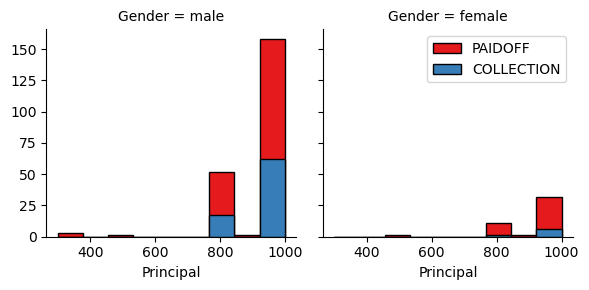

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bins = np.linspace(dfPandas.Principal.min(), dfPandas.Principal.max(), 10)
g = sns.FacetGrid(dfPandas, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

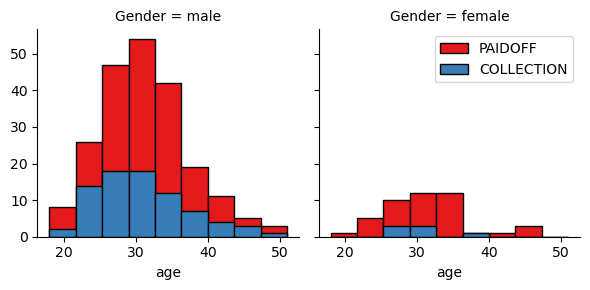

In [11]:
bins = np.linspace(dfPandas.age.min(), dfPandas.age.max(), 10)
g = sns.FacetGrid(dfPandas, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [12]:
import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

app = JupyterDash(__name__)

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options

fig = px.bar(dfPandas, x="age", y="loan_status", color="Gender", barmode="group")

app.layout = html.Div(children=[
    html.H1(children='Hello Dash'),

    html.Div(children='''
        Dash: A web application framework for your data.
    '''),

    dcc.Graph(
        id='example-graph',
        figure=fig
    )
])

app.run_server(mode='inline')


<ipython-input-12-75d8f45bab2a>:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-12-75d8f45bab2a>:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


# Pre-processing:  Feature selection/extraction

Veamos el día de la semana en que la gente recibe el préstamo

In [18]:
dfDayOfWeek = dfDate\
                .withColumn("effective_day",F.date_format('effective_date', 'u'))

In [19]:
#dfDayOfWeek = dfDate\
 #               .withColumn("effective_day",F.dayofweek('effective_date'))

In [20]:
dfDayOfWeekPandas = dfDayOfWeek.toPandas()
dfDayOfWeekPandas.head(5)

_c0  Unnamed: 0 loan_status  Principal  terms effective_date   due_date  \
0    0           0     PAIDOFF       1000     30     2016-09-08 2016-10-07   
1    2           2     PAIDOFF       1000     30     2016-09-08 2016-10-07   
2    3           3     PAIDOFF       1000     15     2016-09-08 2016-09-22   
3    4           4     PAIDOFF       1000     30     2016-09-09 2016-10-08   
4    6           6     PAIDOFF       1000     30     2016-09-09 2016-10-08   

   age             education  Gender effective_day  
0   45  High School or Below    male             4  
1   33              Bechalor  female             4  
2   27               college    male             4  
3   28               college  female             5  
4   29               college    male             5

In [16]:
app = JupyterDash(__name__)

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options
fig = px.scatter(dfDayOfWeekPandas, x="effective_day",
                 y="age", color="loan_status", facet_col="Gender")
#fig = px.bar(dfDayOfWeekPandas, x="effective_day", y="age", color="loan_status", barmode="group")

app.layout = html.Div(children=[
    html.H1(children='Hello Dash'),

    html.Div(children='''
        Dash: A web application framework for your data.
    '''),

    dcc.Graph(
        id='example-graph',
        figure=fig
    )
])

app.run_server(mode='inline')


/media/jose/Repositorio/anaconda3/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [17]:
dfWeekend = dfDayOfWeek\
                .withColumn("weekend",
                            F.when(F.col('effective_day') > 3,1)\
                            .otherwise(0)
                           )

                
dfWeekendPandas = dfWeekend.toPandas()
dfWeekendPandas

_c0  Unnamed: 0 loan_status  Principal  terms effective_date   due_date  \
0      0           0     PAIDOFF       1000     30     2016-09-08 2016-10-07   
1      2           2     PAIDOFF       1000     30     2016-09-08 2016-10-07   
2      3           3     PAIDOFF       1000     15     2016-09-08 2016-09-22   
3      4           4     PAIDOFF       1000     30     2016-09-09 2016-10-08   
4      6           6     PAIDOFF       1000     30     2016-09-09 2016-10-08   
..   ...         ...         ...        ...    ...            ...        ...   
341  394         394  COLLECTION        800     15     2016-09-11 2016-09-25   
342  395         395  COLLECTION       1000     30     2016-09-11 2016-10-10   
343  397         397  COLLECTION        800     15     2016-09-12 2016-09-26   
344  398         398  COLLECTION       1000     30     2016-09-12 2016-11-10   
345  399         399  COLLECTION       1000     30     2016-09-12 2016-10-11   

     age             education  Gender effective_day  weekend  
0     45  High School or Below    male           Thu        0  
1     33              Bechalor  female           Thu        0  
2     27               college    male           Thu        0  
3     28               college  female           Fri        0  
4     29               college    male           Fri        0  
..   ...                   ...     ...           ...      ...  
341   32  High School or Below    male           Sun        0  
342   25  High School or Below    male           Sun        0  
343   39               college    male           Mon        0  
344   28               college    male           Mon        0  
345   26               college    male           Mon        0  

[346 rows x 12 columns]

# Convert Categorical features to numerical values